In [39]:
!pip install keras-tuner -q

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
!nvidia-smi

Tue Jan 24 19:25:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
num_classes = 10
input_shape = (32, 32, 3)
weight_decay = 1e-4

In [42]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

In [43]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True)

In [44]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , num_classes)
y_test = tf.keras.utils.to_categorical(y_test , num_classes)
y_val  = tf.keras.utils.to_categorical(y_val , num_classes)

datagen.fit(x_train)

In [45]:
def results(model):
  epoch = 93

  epoch_range = range(1, 93+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

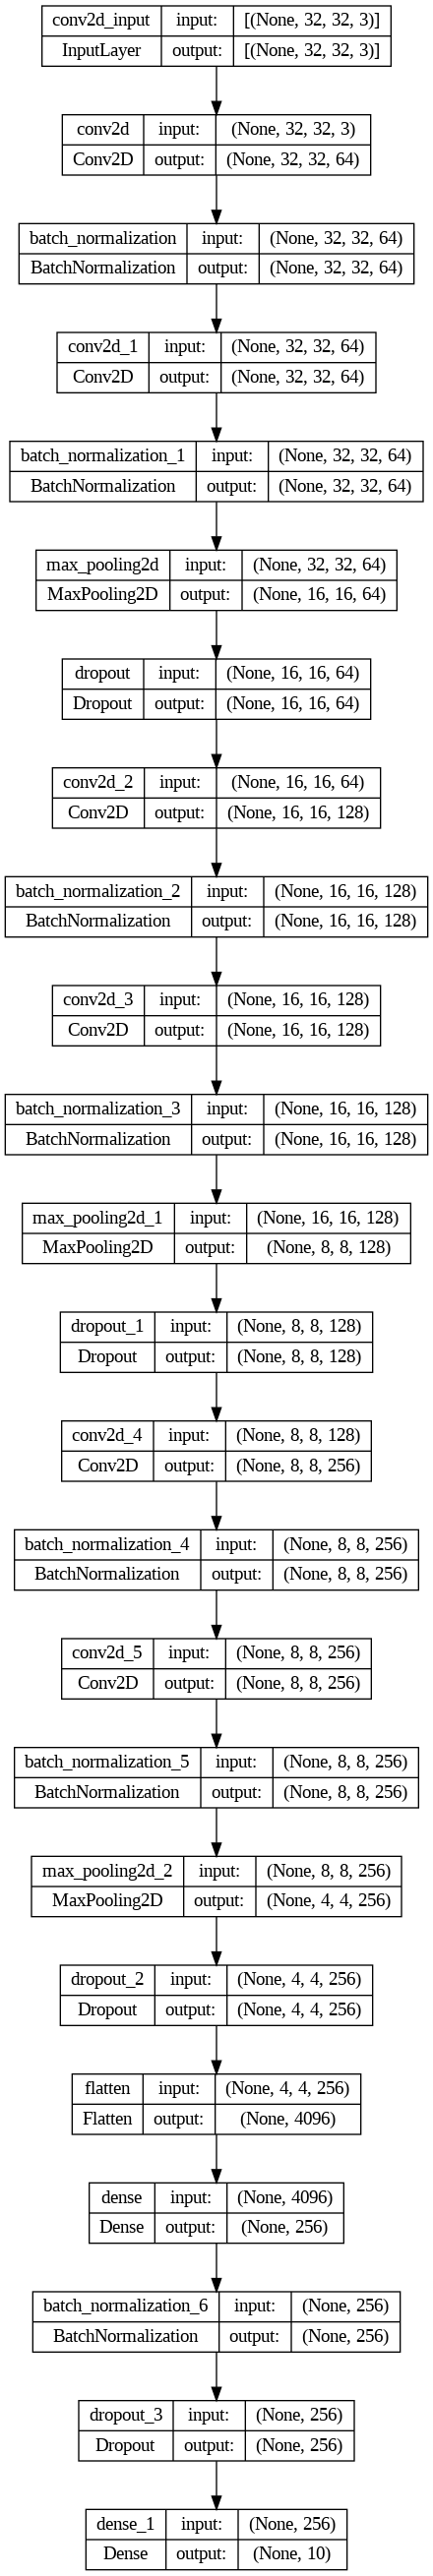

In [46]:
class CustomModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def create_model(self):
      model = Sequential([Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=input_shape),
                          BatchNormalization(),
                          Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.2),

                          Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                          BatchNormalization(),
                          Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.3),

                          Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                          BatchNormalization(),
                          Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                          BatchNormalization(),
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),

                          Flatten(),
                          Dense(256, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(num_classes, activation='softmax')])

      return model

model = CustomModel(input_shape=input_shape, num_classes=num_classes).create_model()

model.summary()

plot_model(model, to_file='model.png', show_shapes=True)

In [47]:
def build_model(hp):
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='/content/gdrive/My Drive/Colab_Models/ImageClassification', project_name='ImageClassification')
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]


Trial 3 Complete [00h 00m 56s]
val_accuracy: 0.6723999977111816

Best val_accuracy So Far: 0.819599986076355
Total elapsed time: 00h 02m 59s


In [48]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [49]:
epoch = 200
history = best_model.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)/64, validation_data = (x_val , y_val) , verbose = 1, callbacks=callbacks)

Epoch 1/200
781/781 [==============================] - 26s 31ms/step - loss: 0.8951 - accuracy: 0.7959 - val_loss: 0.9367 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 2/200
781/781 [==============================] - 24s 31ms/step - loss: 0.8423 - accuracy: 0.8050 - val_loss: 0.7888 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 3/200
781/781 [==============================] - 24s 31ms/step - loss: 0.8296 - accuracy: 0.8108 - val_loss: 0.9121 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 4/200
781/781 [==============================] - 24s 31ms/step - loss: 0.8199 - accuracy: 0.8138 - val_loss: 0.7917 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 5/200
781/781 [==============================] - 24s 30ms/step - loss: 0.8023 - accuracy: 0.8200 - val_loss: 0.8107 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 6/200
781/781 [==============================] - 24s 31ms/step - loss: 0.7962 - accuracy: 0.8225 - val_loss: 0.7692 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 7/200
781/781 [==============================]

In [50]:
# acc = model.evaluate(x_test , y_test)
# print("test set loss : " , acc[0])
# print("test set accuracy :", acc[1]*100)
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (test_acc*100))

Test Accuracy: 91.68%


x and y must have same first dimension, but have shapes (93,) and (119,)


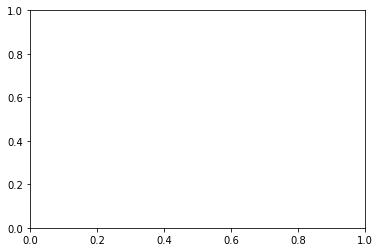

In [51]:
try:
  results(best_model)
except Exception as e:
  print(e)

In [52]:
from google.colab import drive 
drive.mount('/content/gdrive')

model.save("/content/gdrive/My Drive/Colab_Models/model_final/custom_cnn_final.h5")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
from google.colab import runtime
runtime.unassign()